# Model 1 (simple)
As in the [previous model](starting_model.ipynb), even in this case the cell growth is governed by a single trait, which is the size. However, this model is biologically more realistic, mainly because a lower bound is placed on the size of the cell such that it can divide. 

Also in this case the processes considered are growth and division, governed by $g(x)$ and $h(x)$ respectively. In this model we define $g(x)$ and $h(x)$ as follows
$$
\begin{aligned}
g(x)&= \omega_1 x \\
h(x)&=
\begin{cases}
    0  & , \, x<u \\
    \omega_2 \cdot \frac{x+v}{u+v} & , \, x\geq u
\end{cases}
\end{aligned}
$$
where $g(x)$ again corresponds to an exponential growth, while $h(x)$ is lower bounded by $u$. 

The set of parameters is
$$
\underline{\theta}=\{\omega_1, \omega_2, u, v, m_b\}
$$
where $m_b$ is the size at birth and it is the only fixed parameter. The other 4 parameters have to be inferred.  

In this model we implement also the idea that division does not always divide the cell into two equal parts. We introduce then a parameter $\text{f}$ such that after the division
$$
\underline{x}_{div} = \left(\text{f}x, (1-\text{f})x\right)
$$
In this case, we fix $\text{f}=0.5$, so nothing changes from the previous model, but in the future we will treat it as a stochastic variable, like the division time $\tau$.

In [ ]:
import math
import numpy as np
from scipy import stats
#import sympy as smp
from pynverse import inversefunc
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

In [ ]:
np.random.seed(seed=123)

size = 100 # length of the time series (= number of divisions)
s_drawn = np.random.uniform(low=0, high = 1, size = size)
print('Some drawn values of s:', s_drawn[:5])

Some drawn values of s: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


## Parameters value, initial choices
Initially, we can choose arbitrary values for the parameters, as long as they make sense. For this reason, we decide to set and fix
- $\omega_1=1$
- $\nu=1$

Then we chose for now
- $\omega_2=0.9$ 
- $\mu=0.1$, such that $\mu \ll\nu$
- $x_b=1$

## Analytical solution of the differential equations
The result of two differential equations is:
$$
\begin{aligned}

x(t) &= x_b\, e^{\omega_1 t} \\

\ln(s(t)) &= - \left[ \dfrac{x_b}{\mu+\nu} \dfrac{\omega_2}{\omega_1} \left( e^{\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{\nu}{\mu+\nu}\, \omega_2 (t-t_0) \right] \theta(t-t_0) \\

s(t) &= \exp\left\{ - \left[ \dfrac{x_b}{\mu+\nu} \dfrac{\omega_2}{\omega_1} \left( e^{\omega_1 t} - e^{\omega_1 t_0}\right) + \dfrac{\nu}{\mu+\nu}\, \omega_2 (t-t_0) \right] \theta(t-t_0) \right\}


\end{aligned}
$$

where $t_0 \equiv \max\left\{0,\dfrac{1}{\omega_1} \ln\left(\dfrac{\mu}{x_b}\right)\right\}$ is the minimum time at which the cell can divide and $\theta(\tau)$ is the Heaviside function.

**Note that this model is different from the starting one only if the new parameter $t_0$ is bigger than zero, i.e., only if $\mu > x_b$**.

In [ ]:
'''
Cell size evolution x(t)
'''
def x_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    x_ = (xb)*np.exp(omega1*t)
    return x_


'''
Hazard rate function h(t)
'''
def h(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    h_ = omega2*((x_function(t, pars) + nu)/(mu+nu)) # if x(t) ≥ mu
    h_[x_function(t, pars) < mu] = 0                 # if x(t) < mu
    
    return h_


'''
Survival function s(t) for a float t
'''
def CDF_float(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    # threshold time
    t0 = max([0, ((1.0/omega1) * np.log(mu/xb))])

    if t>=t0:
        ln_s_ = - ( (xb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    (nu/(mu+nu)) * omega2 * (t-t0) )
    else:
        ln_s_ = 0
        

    s_ = np.exp(ln_s_)

    return s_


'''
Survival function s(t) for an array t
'''
def CDF_arr(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(mu/xb)])
    
    ln_s_ = - ( (xb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) + (nu/(mu+nu)) * omega2 * (t-t0) )
    ln_s_[t < t0] = 0                 # if x(t) < mu

    s_ = np.exp(ln_s_)
    return s_

    
'''
Survival function s(t)
'''
def CDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    if type(t) == np.ndarray: # array
        s_ = CDF_arr(t, pars)
    else: # float
        s_ = CDF_float(t, pars)

    return s_

In [ ]:
'''
Find tau numerically
'''
def draw_tau_numerical(K, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(mu/xb)])
    
    t_max = 5/omega1 # approx. 5 tau to avoid roundoff error

    tau = inversefunc(CDF, args=(pars,), y_values=K, domain=[t0, t_max], open_domain=True)
    
    return tau

##### Future improvement (?)
Solve $\ln K = \ln s(t)$ instead of $K = s(t)$ to avoid definitevely the roundoff error

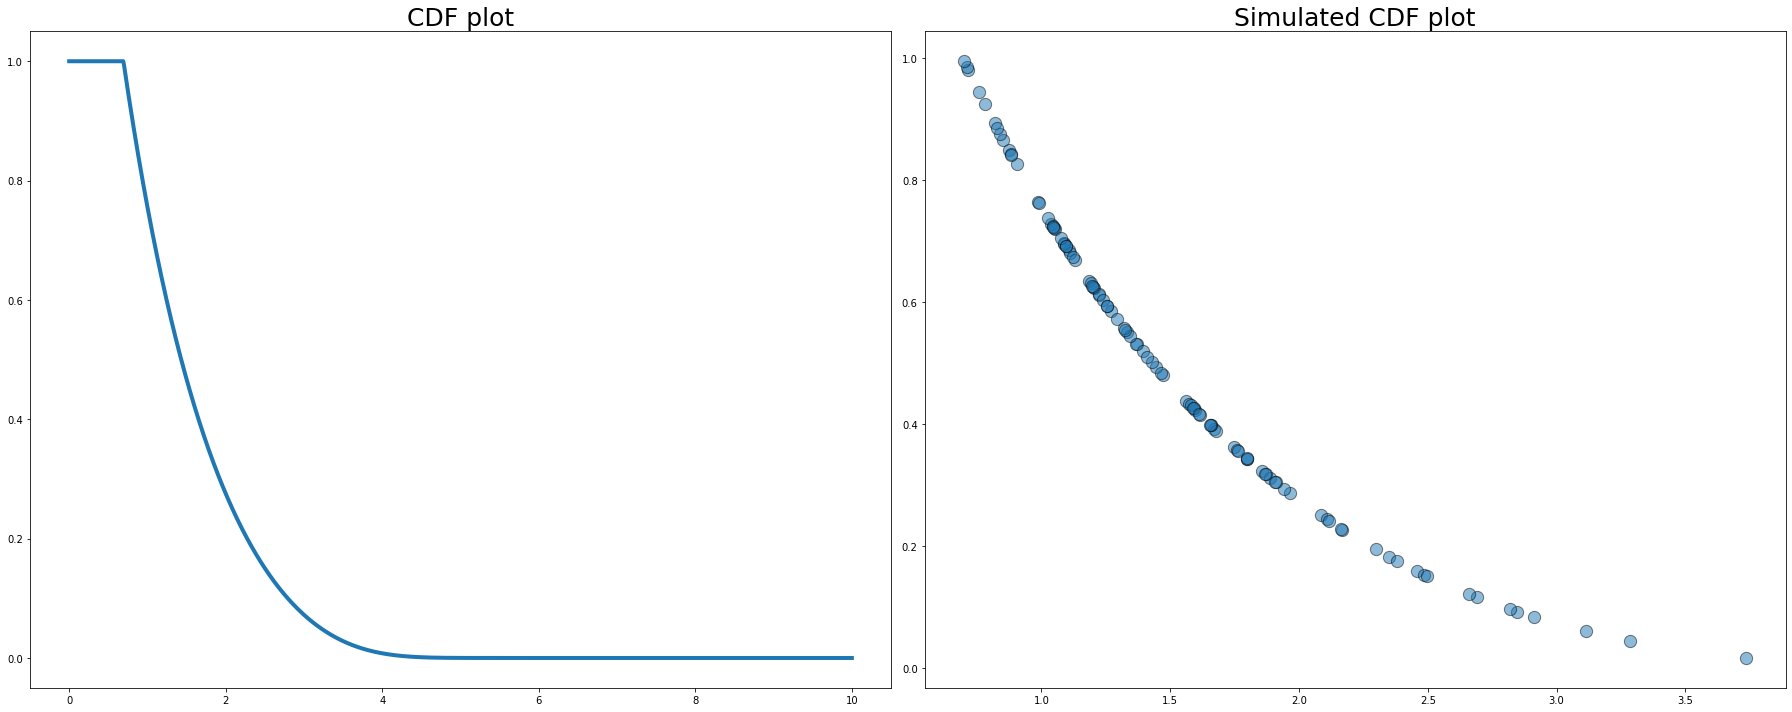

In [ ]:
sim_t = draw_tau_numerical(s_drawn,(1,0.9,0.1,1,0.05))
# plot of CDF
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].plot(np.linspace(0,10,1000), CDF(np.linspace(0,10,1000),(1,0.9,0.1,1,0.05)), linewidth=4)
ax[0].set_title('CDF plot', fontsize=25)
ax[1].set_title('Simulated CDF plot', fontsize=25)
ax[1].scatter(sim_t, CDF(sim_t,(1,0.9,0.1,1,0.05)), alpha=0.5, edgecolor='black', s=150)
fig.tight_layout()

In [ ]:
# numerical inversion of CDF function

#sim_t = draw_tau_numerical(s_drawn)
#sim_t = []

#df_growth = pd.DataFrame({'simulated_tau':sim_t, 's_drawn':s_drawn})

#display(df_growth)

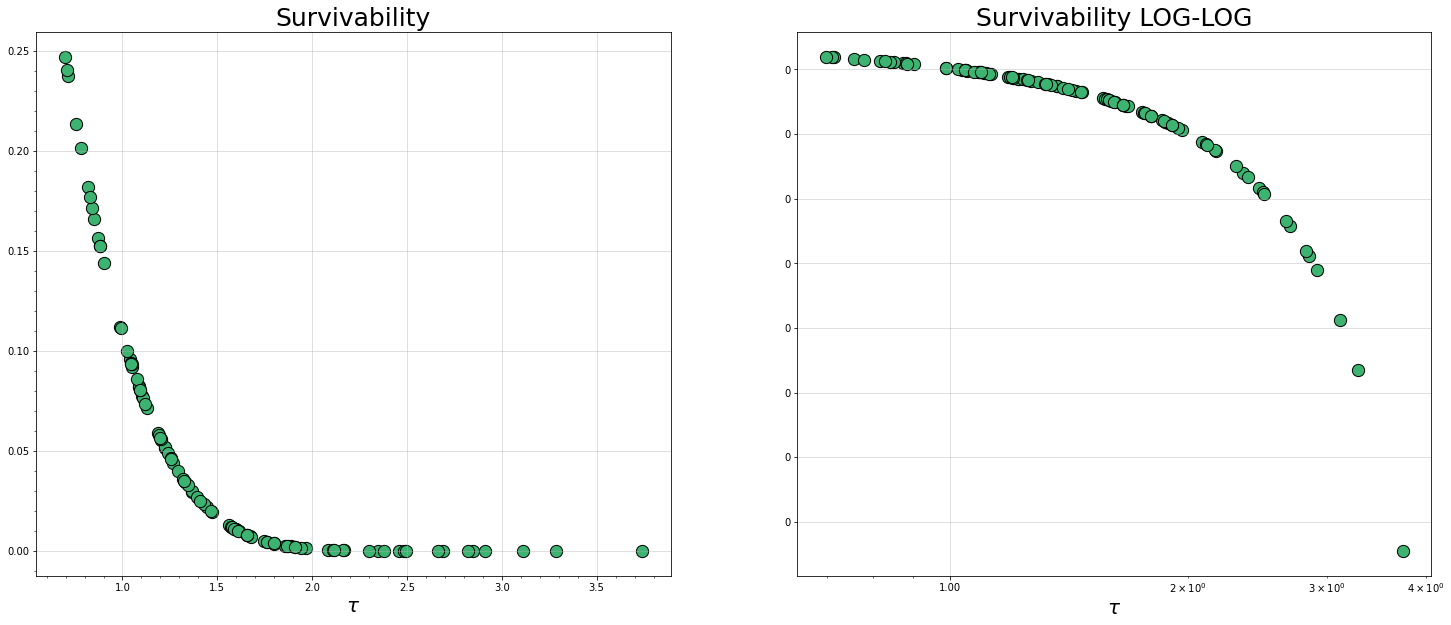

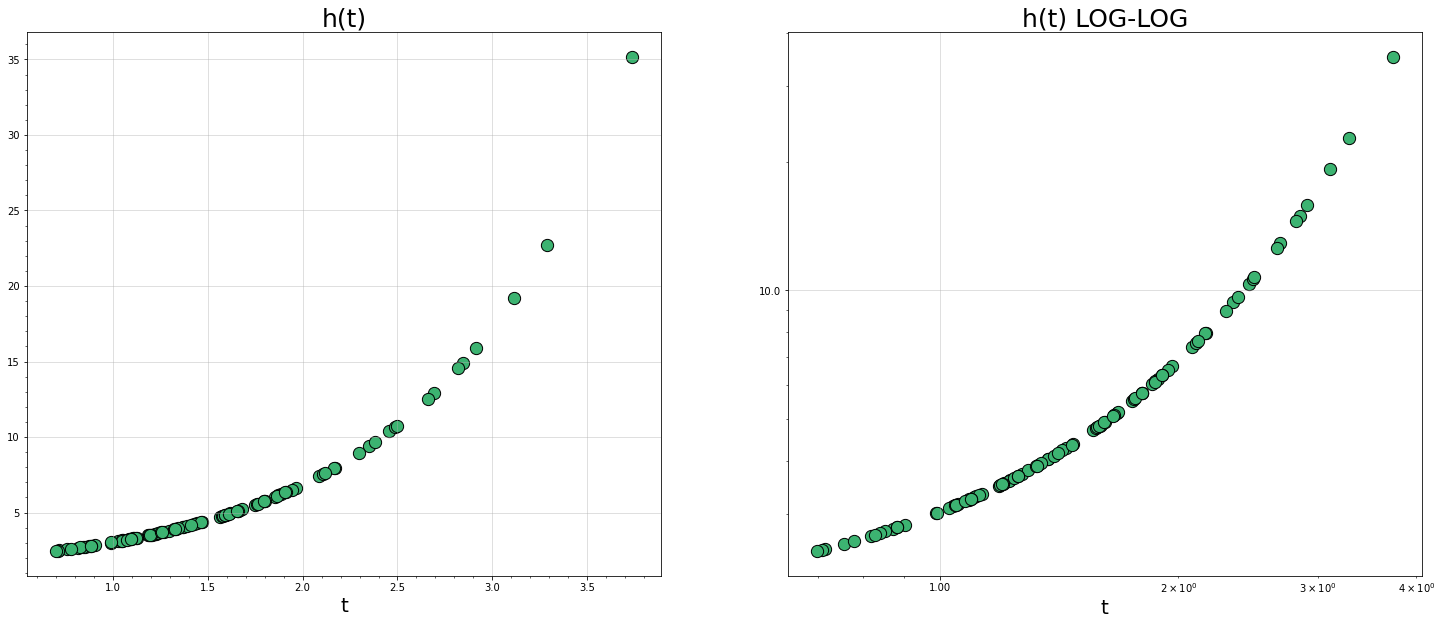

In [ ]:
# PLOT s(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))

ax[0].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('Survivability', fontsize=25)
ax[0].set_xlabel('$\\tau$', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('Survivability LOG-LOG', fontsize=25)
ax[1].set_xlabel('$\\tau$', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


# PLOT h(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))

ax[0].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('h(t)', fontsize=25)
ax[0].set_xlabel('t', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('h(t) LOG-LOG', fontsize=25)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

In [ ]:
points_per_evolution=100     # number of time points between 2 divisions

t = 0
xb = 1
frac = 1/2

all_times = np.zeros(points_per_evolution*size)
cell_sizes = np.zeros(points_per_evolution*size)
sim_t = []

for i in range(size):
     
    parameters = (1,0.9,0.1,1,xb) # omega1, omega2, mu, nu, xb
    tau = draw_tau_numerical(s_drawn[i], pars=parameters)
    sim_t.append(tau)
    #tau = df_growth['simulated_tau'][i]
    
    # evolution
    times = np.linspace(0, tau, points_per_evolution)
    xt = x_function(times, parameters)
    
    # store times and sizes
    all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
    cell_sizes[i*points_per_evolution : (i+1)*points_per_evolution] = xt

    # update the initial time and the starting size
    xb = xt[-1]*frac
    t = t+tau

sim_t = np.array(sim_t)

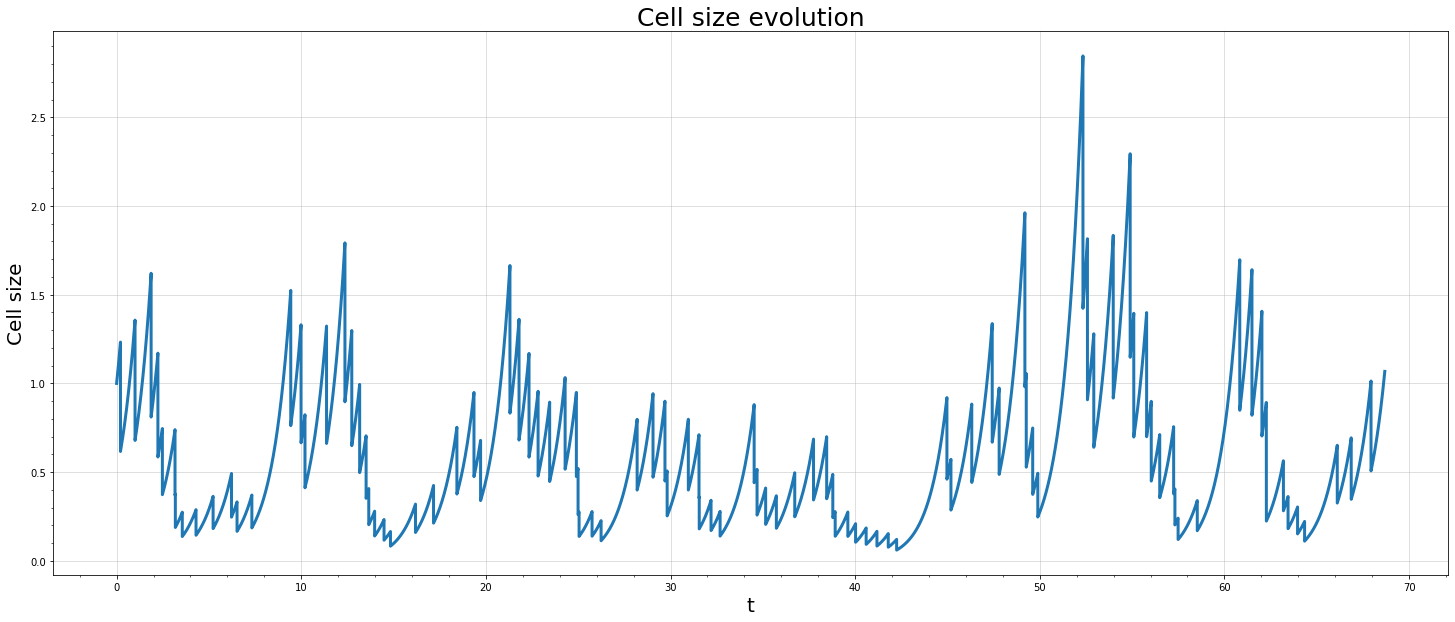

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(25, 10))
ax.plot(all_times, cell_sizes, linewidth=3, color='C0')
ax.set_title('Cell size evolution', fontsize=25)
ax.set_xlabel('t', fontsize = 20)
ax.set_ylabel('Cell size', fontsize=20)
ax.minorticks_on()
ax.grid(alpha=0.5)

In [ ]:
# define the distributions
def prior_omega2(omega2):
    return(stats.lognorm.pdf(omega2, s=np.sqrt(1/3 - np.log(0.9)), loc=0, scale=np.exp(1/3 )))

def prior_mu(mu):
    return(stats.beta.pdf(mu, a=2, b=5))

def prior_nu(nu):
    return(stats.lognorm.pdf(nu, s=1/3, loc=0.1, scale=np.exp(1/9)))

def prior_omega1(omega1):
    return(stats.lognorm.pdf(omega1, s=1/3, loc=0, scale=np.exp(1/9)))

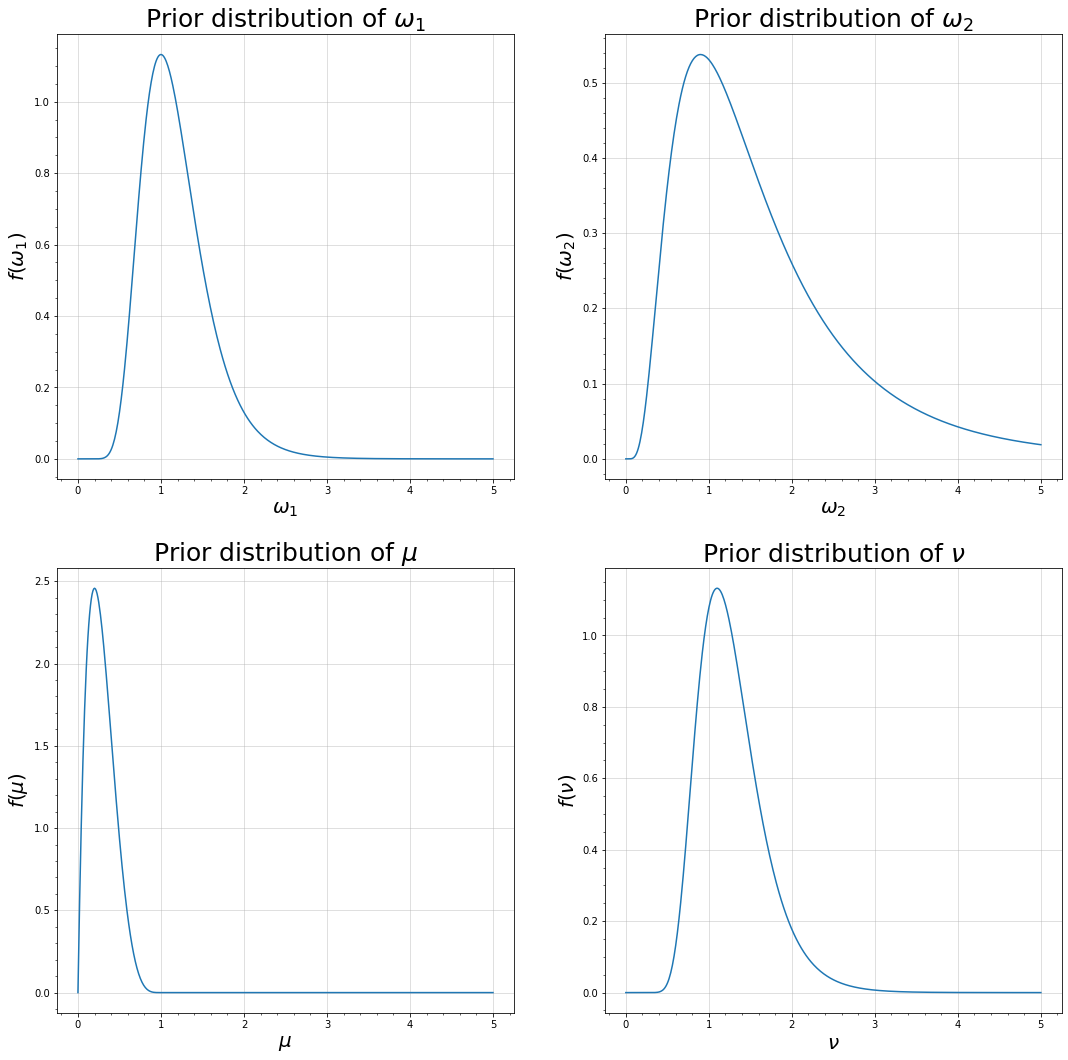

In [ ]:
x = np.linspace(0, 5, 500)

_, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0, 0].plot(x, prior_omega1(x))
ax[0, 1].plot(x, prior_omega2(x)) 
ax[1, 0].plot(x, prior_mu(x)) 
ax[1, 1].plot(x, prior_nu(x))

param_str = [['$\omega_1$', '$\omega_2$'], ['$\mu$', '$\\nu$']]

for i in range(2):
    for j in range(2):
        ax[i, j].set_title('Prior distribution of ' + param_str[i][j], fontsize=25)
        ax[i, j].set_xlabel(param_str[i][j], fontsize=20)
        ax[i, j].set_ylabel('$f($'+param_str[i][j]+'$)$', fontsize=20)
        ax[i, j].minorticks_on()
        ax[i, j].grid(alpha=0.5)


## Likelihood

To retrieve the likelihood we first retrieve the pdf as minus the derivative of the cdf.
We then have that 
$$
f(y|\theta) = \prod_i f(t_i|t_{i-1,..}, \theta)
$$

In [ ]:
def PDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h(t, pars)*CDF(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)

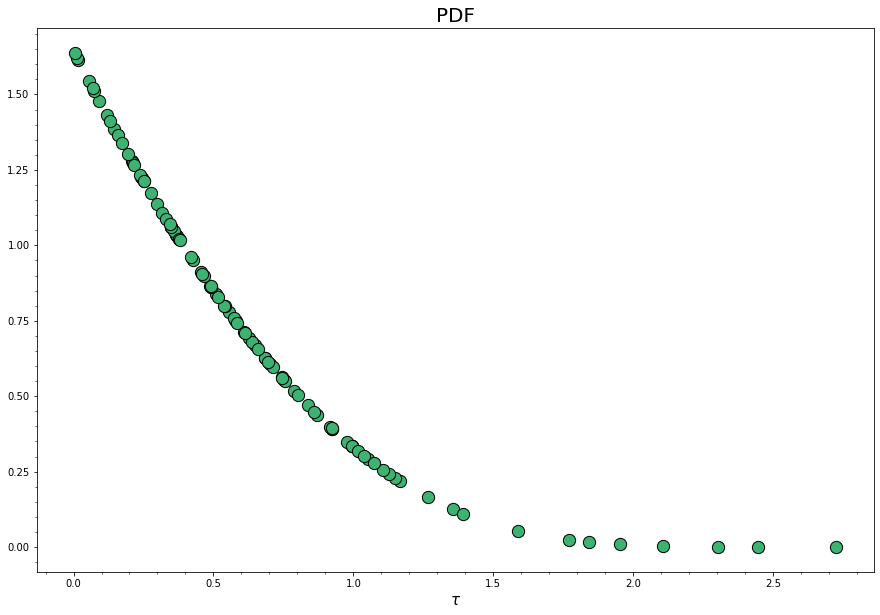

In [ ]:
def likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.prod(PDF_arr(y, pars))

def log_likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.sum(np.log(PDF(y, pars)))

fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.scatter(sim_t, PDF(sim_t, pars=(1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax.set_title('PDF', fontsize=20)
ax.set_xlabel('$\\tau$', fontsize = 15)
ax.minorticks_on()

## Metropolis Monte Carlo (emcee)

In [ ]:
n_walkers = 20
ndim = 4

def j_log_unnorm_posterior_emcee(params, y_times):
    try:
        omega_1, omega_2, u, nu = np.array(params)
        
        #return(log_likelihood(y_times, pars=(1, omega_2, u, 1, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1))
    except:
        #omega_1, omega_2, u = np.array([0.00001, 0.000001, 0.00001])
        post_arr = [1, 0.9, 0.1, 1]
    
    ret = log_likelihood(y_times, pars=(omega_1, omega_2, u, nu, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu))
    if ret*0 == 0:
        return(ret)
    else:
        return(-np.inf)
    

In [ ]:
p0_u = np.random.uniform(low=0.01, high=0.3, size=n_walkers).reshape(-1, 1)
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_omega_1 = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)

p0 = np.hstack([p0_omega_1, p0_omega_2, p0_u, p0_nu])

sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times':sim_t}, a=1)
'''
4   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

samples = sampler.run_mcmc(p0, 5000)
chain = sampler.get_chain(flat=True) # omega_1, omega_2, mu, nu

'''
p0   is the initial state
5000 is the number of steps to run
'''


<ipython-input-3-c98fce3d07e4>:51: RuntimeWarning: invalid value encountered in log
  t0 = max([0, (1.0/omega1) * np.log(mu/xb)])
<ipython-input-14-eb11abd8cce2>:13: RuntimeWarning: divide by zero encountered in log
  ret = log_likelihood(y_times, pars=(omega_1, omega_2, u, nu, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu))
<ipython-input-14-eb11abd8cce2>:14: RuntimeWarning: invalid value encountered in double_scalars
  if ret*0 == 0:
<ipython-input-13-3ac2ba0f1ba5>:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(PDF(y, pars)))
<ipython-input-3-c98fce3d07e4>:56: RuntimeWarning: overflow encountered in exp
  s_ = np.exp(ln_s_)
<ipython-input-12-325457283768>:8: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalization)
<ipython-input-13-3ac2ba0f1ba5>:5: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(PDF(y, pars)))


'\np0   is the initial state\n5000 is the number of steps to run\n'

Median value of omega_1: 0.751
Max value of omega_1: 0.76
true value of omega_1: 1.0


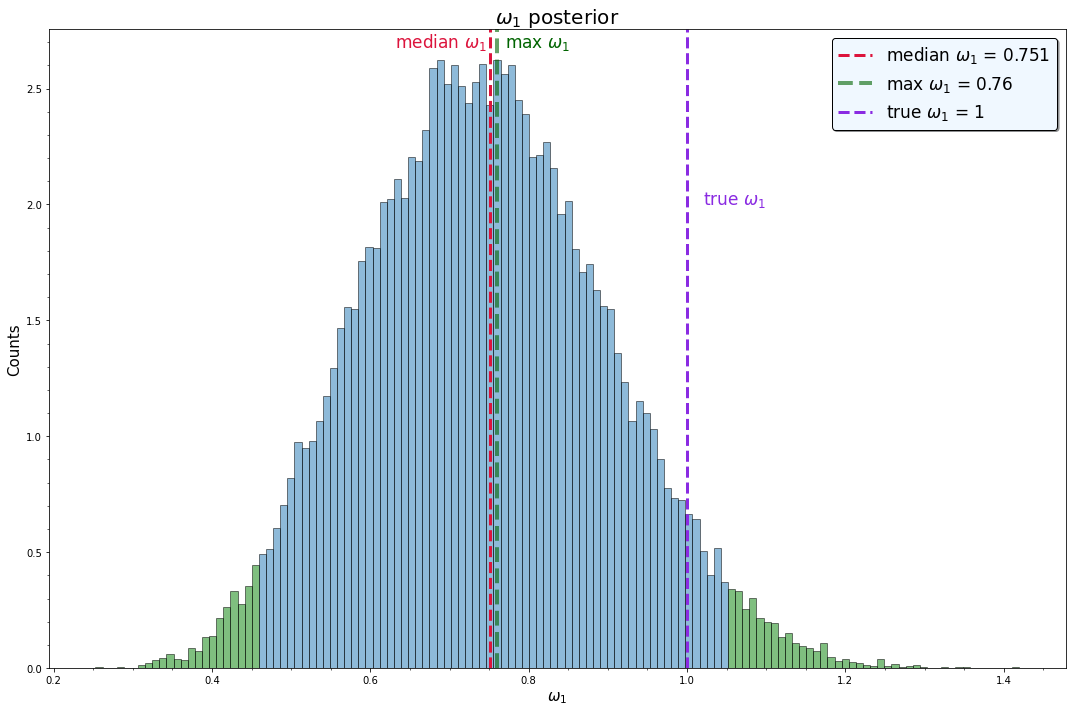

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
res_omega_1 = ax.hist(chain[:,0], bins='fd', edgecolor='black', alpha=0.5, density=True)

counts_omega_1 = res_omega_1[0]
edges_omega_1 = res_omega_1[1]
patches_omega_1 = res_omega_1[2]
tmp = np.cumsum(np.diff(edges_omega_1)*counts_omega_1)

max_index = np.argmax(counts_omega_1)
max_omega_1 = (edges_omega_1[max_index] + edges_omega_1[max_index + 1])/2
median_omega_1 = (edges_omega_1[len(tmp[tmp<0.5])+1] + edges_omega_1[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_1:', round(median_omega_1, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_1[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_1[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_1$', fontsize=15)
ax.set_title('$\\omega_1$ posterior', fontsize=20)
ax.axvline(median_omega_1, color='crimson', linestyle='dashed',  linewidth=3, label='median $\omega_1$ = ' + str(round(median_omega_1, 4)))
ax.axvline(max_omega_1, color='darkgreen', linestyle='dashed',  linewidth=4, alpha=0.6, label='max $\omega_1$ = ' + str(round(max_omega_1, 4)))
ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_1$ = 1')

ax.text(median_omega_1-0.12, 2.68, 'median $\omega_1$' , color='crimson', fontsize=17)
ax.text(max_omega_1+0.01, 2.68, 'max $\omega_1$', color='darkgreen', fontsize=17)
ax.text(1 + 0.02, 2, 'true $\omega_1$', color='blueviolet', fontsize=17)


print('Max value of omega_1:', round(max_omega_1, 4))
print('true value of omega_1:', 1.)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

fig.tight_layout()

Median value of omega_2: 0.8064
Max value of omega_2: 0.7821
true value of omega_2: 0.9


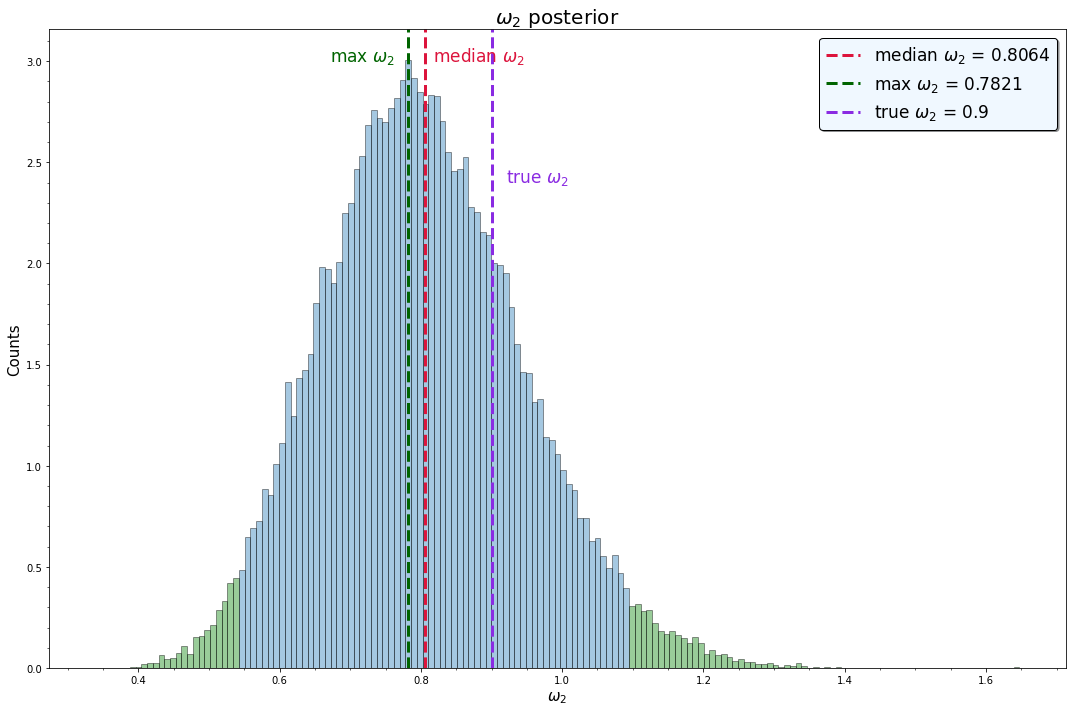

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))



res_omega_2 = ax.hist(chain[:,1], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_omega_2 = res_omega_2[0]
edges_omega_2 = res_omega_2[1]
patches_omega_2 = res_omega_2[2]
tmp = np.cumsum(np.diff(edges_omega_2)*counts_omega_2)

max_index = np.argmax(counts_omega_2)
max_omega_2 = (edges_omega_2[max_index] + edges_omega_2[max_index + 1])/2
median_omega_2 = (edges_omega_2[len(tmp[tmp<0.5])+1] + edges_omega_2[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_2:', round(median_omega_2, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_2[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_2[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_title('$\\omega_2$ posterior', fontsize=20)
ax.axvline(median_omega_2, color='crimson', linestyle='dashed',  linewidth=3 , label='median $\omega_2$ = ' + str(round(median_omega_2, 4)))
ax.axvline(max_omega_2, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\omega_2$ = ' + str(round(max_omega_2, 4)))
ax.axvline(0.9, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_2$ = 0.9')

ax.text(median_omega_2+0.011, 3, 'median $\omega_2$', color='crimson', fontsize=17)
ax.text(max_omega_2-0.11, 3, 'max $\omega_2$', color='darkgreen', fontsize=17)

ax.text(0.9 + 0.02, 2.4, 'true $\omega_2$', color='blueviolet', fontsize=17)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
print('Max value of omega_2:', round(max_omega_2, 4))
print('true value of omega_2:', 0.9)


fig.tight_layout()

Median value of mu: 0.2935
Max value of mu: 0.2836
true value of mu: 0.1


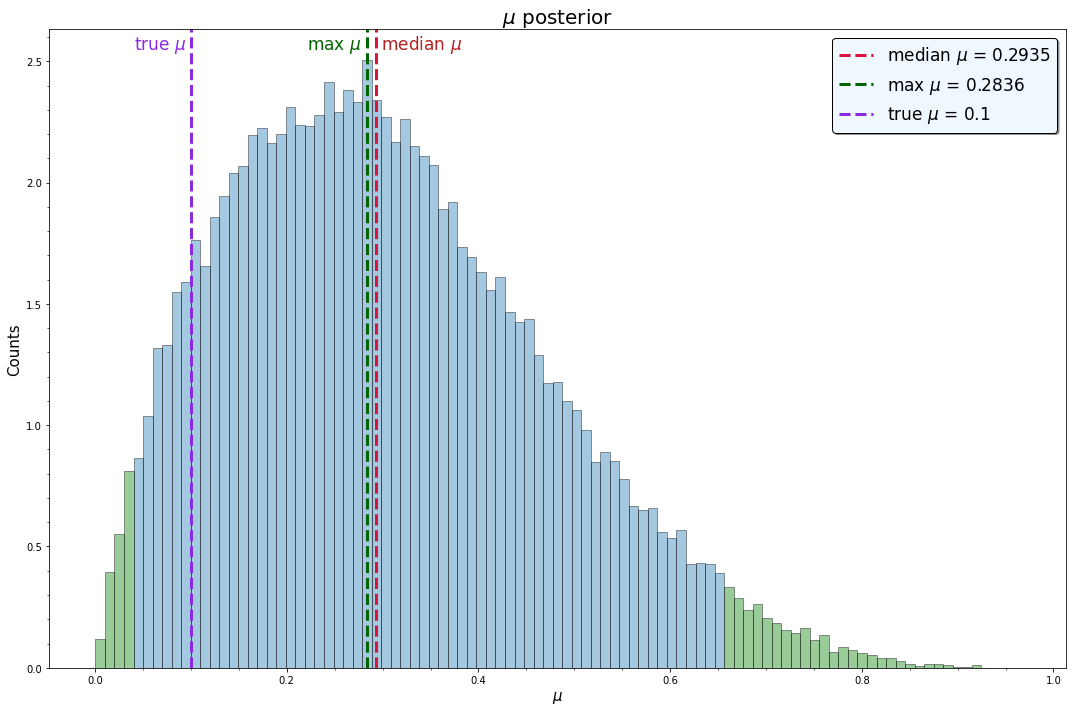

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_mu = ax.hist(chain[:,2], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_mu = res_mu[0]
edges_mu = res_mu[1]
patches_mu = res_mu[2]
tmp = np.cumsum(np.diff(edges_mu)*counts_mu)

max_index = np.argmax(counts_mu)
max_mu = (edges_mu[max_index] + edges_mu[max_index + 1])/2
median_mu = (edges_mu[len(tmp[tmp<0.5])+1] + edges_mu[len(tmp[tmp<0.5])+2])/2
print('Median value of mu:', round(median_mu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_mu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_mu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\mu$', fontsize=15)
ax.set_title('$\\mu$ posterior', fontsize=20)
ax.axvline(median_mu, color='crimson', linestyle='dashed',  linewidth=3, label='median $\mu$ = ' + str(round(median_mu, 4)))
ax.axvline(max_mu, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\mu$ = ' + str(round(max_mu, 4)))
ax.axvline(0.1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\mu$ = 0.1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
ax.text(median_mu+0.005, 2.55, 'median $\mu$', color='firebrick', fontsize=17)
ax.text(max_mu-0.062, 2.55, 'max $\mu$ ', color='darkgreen', fontsize=17)
ax.text(0.1-0.059, 2.55, 'true $\mu$', color='blueviolet', fontsize=17)
print('Max value of mu:', round(max_mu, 4))
print('true value of mu:', 0.1)


fig.tight_layout()

Median value of nu: 1.3525
Max value of nu: 1.1434
true value of nu: 1


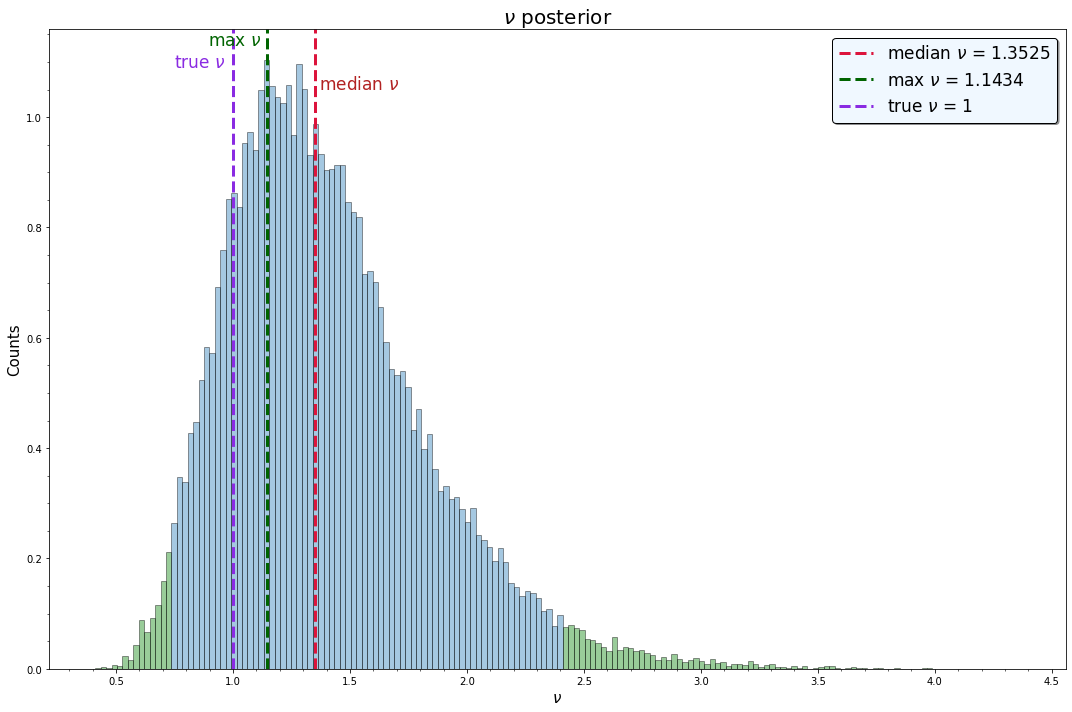

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_nu = ax.hist(chain[:,3], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_nu = res_nu[0]
edges_nu = res_nu[1]
patches_nu = res_nu[2]
tmp = np.cumsum(np.diff(edges_nu)*counts_nu)

max_index = np.argmax(counts_nu)
max_nu = (edges_nu[max_index] + edges_nu[max_index + 1])/2
median_nu = (edges_nu[len(tmp[tmp<0.5])+1] + edges_nu[len(tmp[tmp<0.5])+2])/2
print('Median value of nu:', round(median_nu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_nu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_nu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\nu$', fontsize=15)
ax.set_title('$\\nu$ posterior', fontsize=20)
ax.axvline(median_nu, color='crimson', linestyle='dashed',  linewidth=3, label='median $\\nu$ = ' + str(round(median_nu, 4)))
ax.axvline(max_nu, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\\nu$ = ' + str(round(max_nu, 4)))
ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\\nu$ = 1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

ax.text(median_nu+0.015, 1.05, 'median $ \\nu $', color='firebrick', fontsize=17)
ax.text(max_nu-0.25, 1.13, 'max $ \\nu $ ', color='darkgreen', fontsize=17)
ax.text(1 - 0.25, 1.09, 'true $ \\nu $', color='blueviolet', fontsize=17)

print('Max value of nu:', round(max_nu, 4))
print('true value of nu:', 1)


fig.tight_layout()

In [ ]:
chain_df = pd.DataFrame(chain, columns=['omega1', 'omega2', 'mu', 'nu'])

chain_df.head()

,omega1,omega2,mu,nu
0,0.665329,1.133739,0.158807,0.906750
1,0.851695,0.675701,0.214523,1.286193
2,1.145186,0.741830,0.062814,0.963793
3,0.998303,0.864007,0.047960,0.659433
4,0.807006,0.862284,0.134595,0.859354


/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: Th

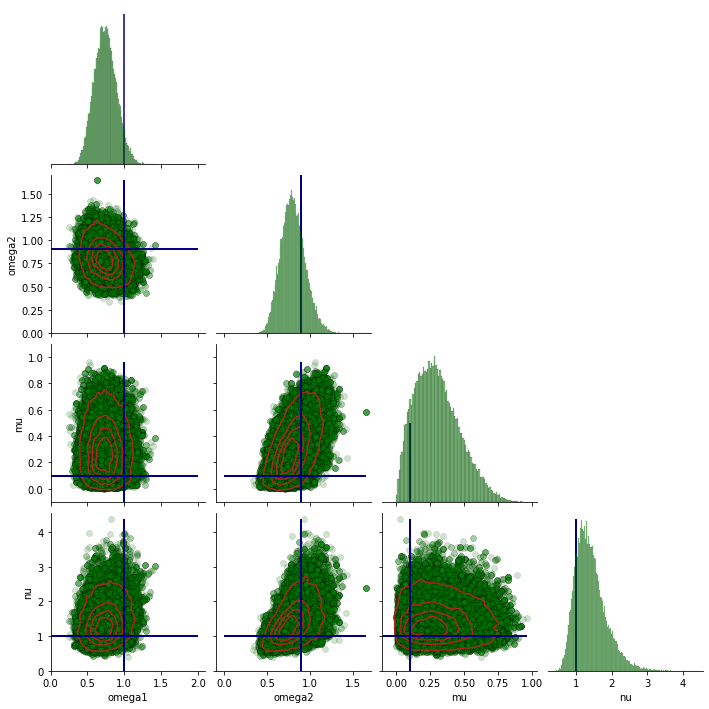

In [ ]:
# it takes 10 to 15 minutes to run this block

g = sns.pairplot(chain_df, diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.2}, diag_kws={'color':'green', 'alpha':0.5})
g.map_lower(sns.kdeplot, levels=5, color="firebrick", linewidth=2.5)
axes = g.axes.ravel()
axes_2 = []
for ax in axes:
    if ax != None:
        axes_2.append(ax)
axes_2
axes_2[0].vlines(x=1, ymin=0, ymax=1, color='navy')
axes_2[0].set_ylim(bottom=0)
axes_2[1].hlines(y=0.9, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[1].vlines(x=1, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[1].set_ylim(bottom=0, top=1.7)
axes_2[2].vlines(x=0.9, ymin=0, ymax=6, linewidth=2, color='navy')
axes_2[2].set_ylim(bottom=0)
axes_2[3].vlines(x=1, ymin=-0.1, ymax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[3].hlines(y=0.1, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[4].vlines(x=0.9, ymin=-0.1, ymax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[4].set_ylim(bottom=-0.1, top=1.1)
axes_2[4].hlines(y=0.1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[5].vlines(x=0.1, ymin=-0.1, ymax=0.5, linewidth=2, color='navy')
axes_2[6].vlines(x=1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')
axes_2[6].hlines(y=1, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[6].set_xlim(left=0)
axes_2[6].set_ylim(bottom=0)
axes_2[7].vlines(x=0.9, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')
axes_2[7].hlines(y=1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[8].vlines(x=0.1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')
axes_2[8].hlines(y=1, xmin=-0.1, xmax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[8].set_xlim(left=-0.1)
axes_2[9].vlines(x=1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')



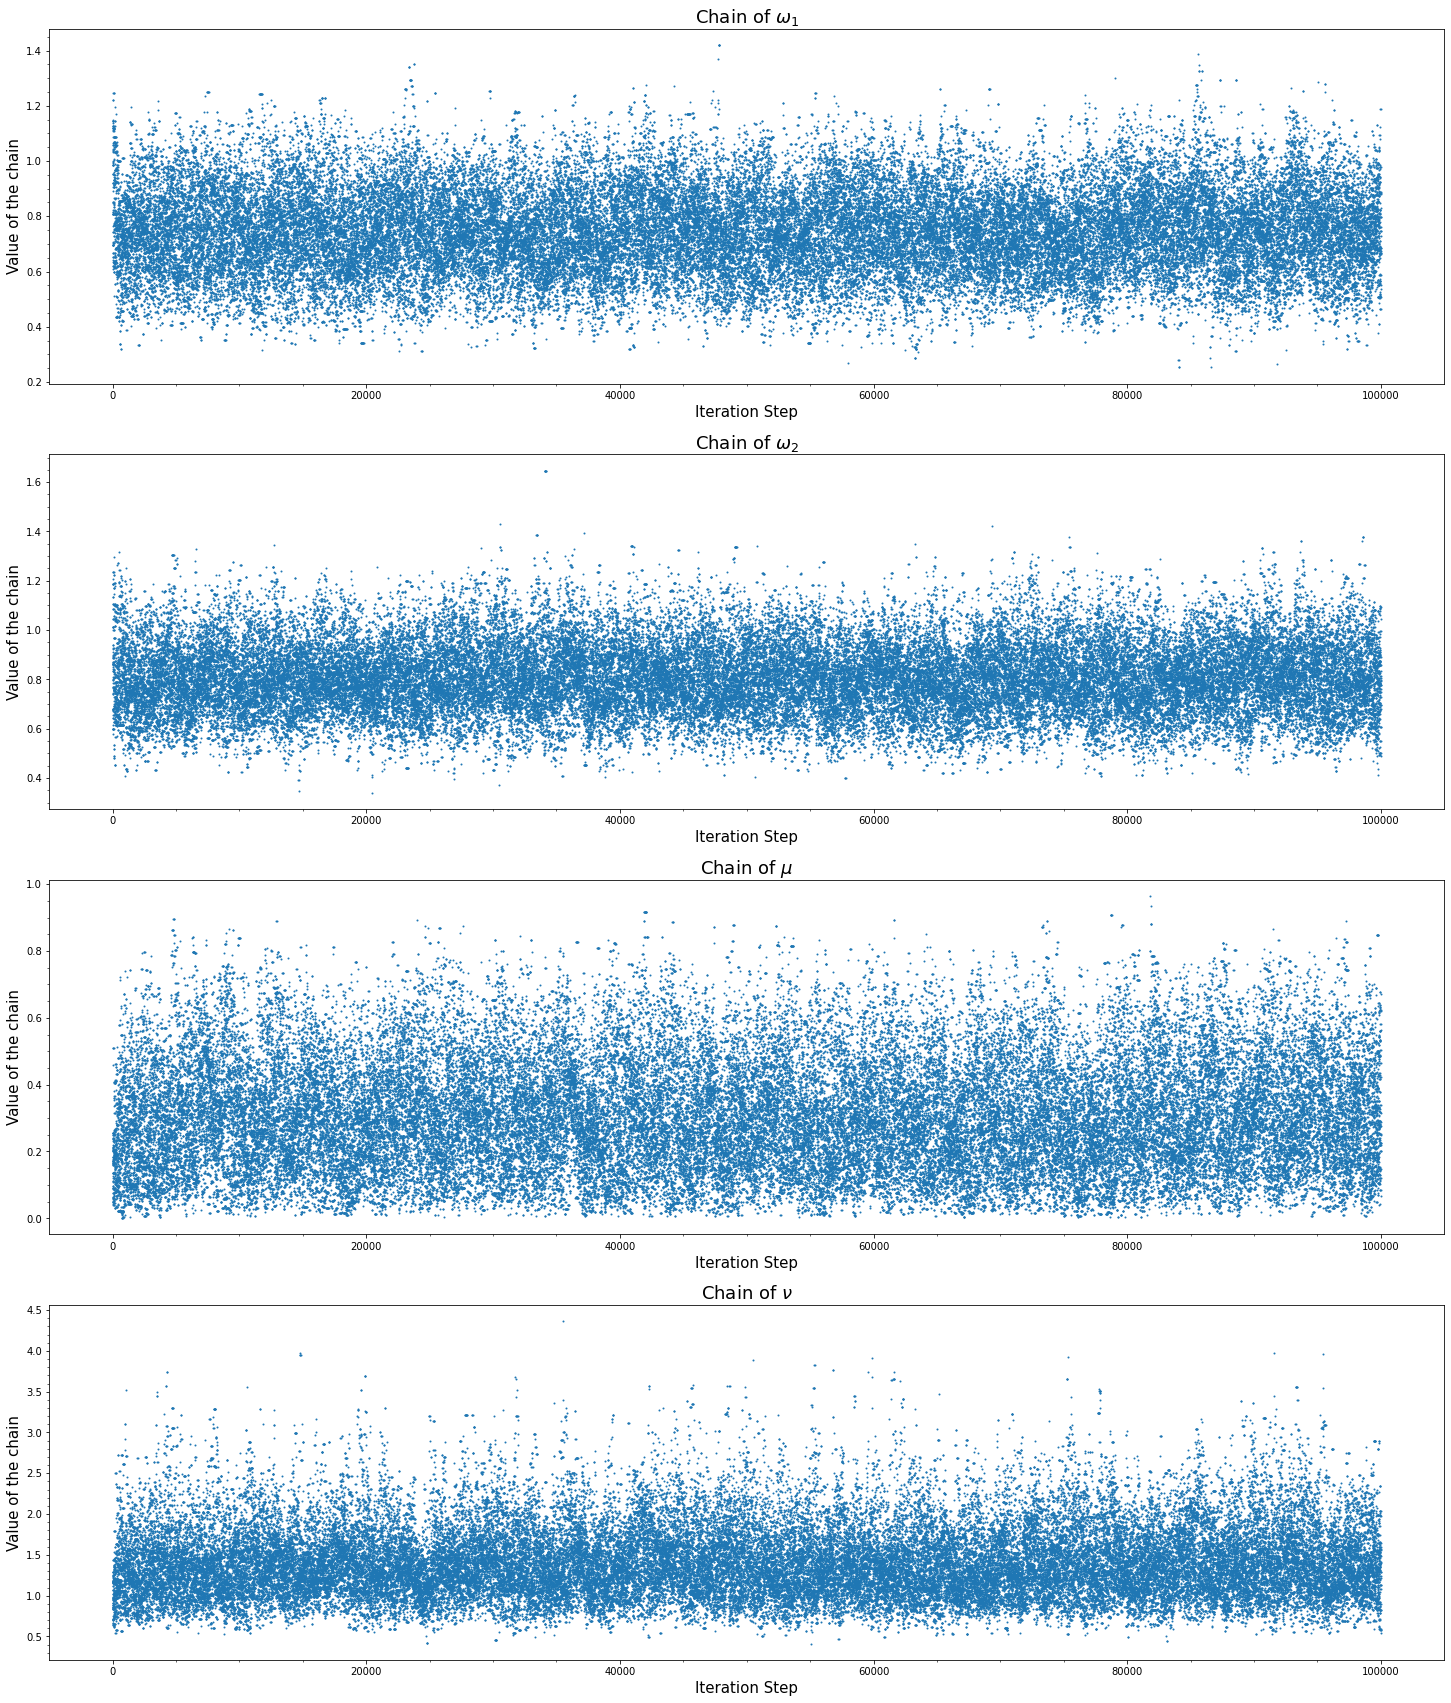

In [ ]:
fig , ax = plt.subplots(4,1, figsize=(25, 30))

title_list = ['$\omega_1$', '$\omega_2$', '$\mu$', '$\\nu$']
for i, i_title in zip(range(4), title_list):
    ax[i].scatter(range(0,100000) , chain[:100000,i], s=1)
    ax[i].set_ylabel('Value of the chain', fontsize=15)
    ax[i].set_xlabel('Iteration Step', fontsize=15)
    ax[i].set_title('Chain of '+i_title, fontsize=18)
    ax[i].minorticks_on()


# References
- Held J, Lorimer T, Pomati F, Stoop R, Albert C. Second-order phase transition in phytoplankton trait dynamics. _Chaos_. 2020;30(5):053109. doi:10.1063/1.5141755 
- emcee documentation: https://emcee.readthedocs.io/en/stable/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>